# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from helios import intensity_estimation

# Dataset and Subdivision

In [2]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# changing the month values for the year 2005 (1 = 13, 2 = 14, etc.) to make subdivision simpler later on
# in rows where the year value is 2005, add 12 to the month value and replace the old month value
df['month'] = np.where((df['year'] == 2005), df['month'] + 12, df['month'])

# list that will hold sets of 4 with a two month overlap
dfs = []

# grouping the data frame by month nummber
df_m = df.groupby(['month'])

# looping starting at i = 4, in steps of 2, while i < 25
# creates an overlap of two months between subsets
for i in range(4, 25, 2):
    # get groups for i - 3th, i - 2th, i - 1th, and ith months, 
    # concatenate them into a single data frame, then append this to the dfs list
    dfs.append(pd.concat([df_m.get_group(i - 3), df_m.get_group(i - 2), df_m.get_group(i - 1), df_m.get_group(i)]))

# Hotspot Discovery

## Finding Thresholds `d1` and `d2`

d2: 5.979787772622579e-07, 
d1: 1.4284527760426358e-06


c:\Users\bs\source\data_science\helios-group-project\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bs\source\data_science\helios-group-project\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


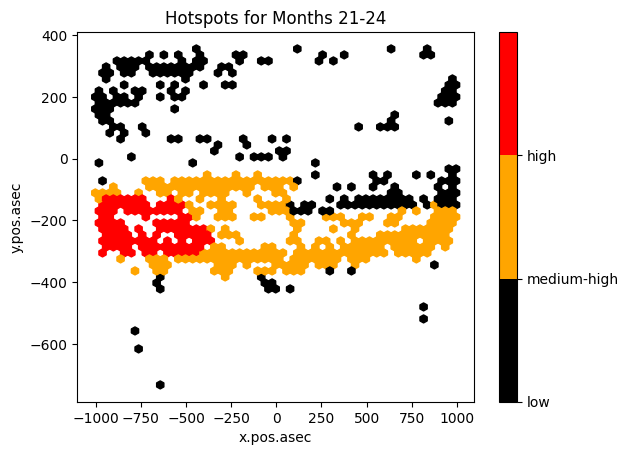

In [6]:
def thresholds(data):
    """For each subset of data, get the potential threshold values for hotspots"""
    
    ticks = []

    # loop through each subset
    for set in data:
        # append the potential threshold values to the ticks list
        # a level value of [0, 0.25, 0.5, 0.75, 1] will return 5 intensity values where each
        # corresponds with a probability mass of 0%, 25%, and so on
        ticks.append(intensity_estimation(set, plot=True, levels=[0, 0.25, 0.5, 0.99, 1]))
    
    # numpy mean will get the element-wise mean for all the potential threshold values
    # from here, we can select the d1 and d2 threshold values from this list, like t[2] for the med
    # hotspots and t[3] for the intense hotspots
    t = np.mean(ticks, axis=0)

    # returning d2, d1
    return (t[2], t[3])

def hotspots(data, d2, d1):
    # getting the intensity values based on frequency for this data set
    intesities = intensity_estimation(data)
    # assigning them in a new column in the dataframe
    data['intensity.estimation'] = intesities

    # new empty array that will contain the classification for the solar flare
    intensity_classifications = np.empty(shape=len(data), dtype=np.int32)
    # assigning a new column in the dataframe
    data['intensity.class'] = intensity_classifications

    # classifying each hotspot as either 0: low intensity, 1: medium-high intensity, or 2: high intensity 
    data['intensity.class'] = np.where((data['intensity.estimation'] < d2 ), 0, data['intensity.class'])
    data['intensity.class'] = np.where(((data['intensity.estimation'] >= d2) & (data['intensity.estimation'] < d1)), 1, data['intensity.class'] )
    data['intensity.class'] = np.where((data['intensity.estimation'] >= d1 ), 2, data['intensity.class'])

    # list of colors for the hotspot plot
    colors = ['black','orange','red']

    # list of identifiers for the hotspots
    hotspot_type = ['low', 'medium-high', 'high']

    x = data['x.pos.asec'].values.flatten()
    y = data['y.pos.asec'].values.flatten()
    c = data['intensity.class'].values.flatten()

    plt.figure()
    plt.hexbin(x=x, y=y, C=c, cmap=matplotlib.colors.ListedColormap(colors), gridsize=50)
    cb = plt.colorbar()
    loc = np.arange(0,max(c),max(c)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(hotspot_type)
    plt.xlabel('x.pos.asec')
    plt.ylabel('y.pos.asec')
    plt.title(f"Hotspots for Months {data['month'].min()}-{data['month'].max()}")
    date_range = f"{data['year'].iloc[0]}_{data['month'].min()}-{data['month'].max()}"
    plt.savefig(f"./output/hotspots_{date_range}.png")
    plt.show()

# example usage

# getting the threshold values for the 11 subsets in the 2004-2005 data
d2, d1 = thresholds(dfs)

print(f"d2: {d2}, \nd1: {d1}")

# taking a subset of data (months 21-24)
flares = dfs[-1]

# getting the hotspots for this subset
hotspots(flares, d2, d1)

## Time Series Using `d1` and `d2` Threshold values

## `d2` Hotspots

## `d1` Hotspots